# Fshion Mnist Dataset Artificial Neural Network using Pytorch with CUDA GPU Support

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import kagglehub
import random
import matplotlib.pyplot as plt

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Loading the Dataset

In [4]:
dataset_path = kagglehub.dataset_download('zalando-research/fashionmnist')
csv_file_path = f'{dataset_path}/fashion-mnist_train.csv'
df_train = pd.read_csv(csv_file_path)

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_train.shape

(60000, 785)

In [7]:
csv_file_path = f'{dataset_path}/fashion-mnist_test.csv'
df_test = pd.read_csv(csv_file_path)

In [8]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_test.shape

(10000, 785)

## Viewing the Random Image

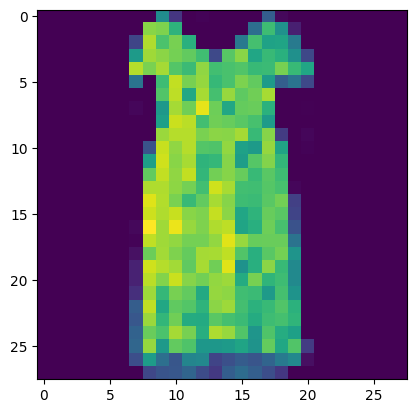

In [10]:
# train image
random_index = random.randint(0,len(df_train))
image = df_train.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

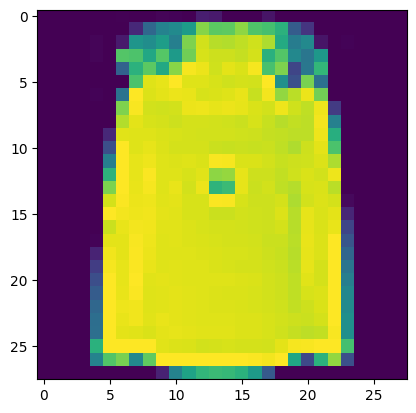

In [11]:
# test image
random_index = random.randint(0,len(df_test))
image = df_test.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

## Splitting the Dataset into Training and Testing Sets

In [12]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Crating Custom Dataset Class

In [14]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [15]:
train_datataset = CustomDataset(features=X_train, labels=y_train)
test_datataset = CustomDataset(features=X_test, labels=y_test)

In [16]:
train_dataloader = DataLoader(train_datataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_datataset, batch_size=32, shuffle=False, pin_memory=True)

## Model Building, Training and Evaluation

In [17]:
# crating model Class
class Model(nn.Module):

    def __init__(self, num_features):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self, features):
        return self.model(features)

In [18]:
learning_rate=0.1
epochs=100

In [19]:
# creatind model object of Mode Class we creates above
model = Model(num_features=X_train.shape[1]).to(device)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer 
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

In [20]:
# training loop
for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        y_pred = model(batch_features)
        
        # loss calculate
        loss = loss_function(y_pred, batch_labels)
        
        # clear gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # calculate loss for each batchs
        total_epoch_loss += loss.item()

    # average loss of batches
    avg_loss = total_epoch_loss/len(train_dataloader)

    print(f"Epoch: {epoch + 1}, Loss:{avg_loss}")

Epoch: 1, Loss:0.6082917017300924
Epoch: 2, Loss:0.41373233878215154
Epoch: 3, Loss:0.3712559998671214
Epoch: 4, Loss:0.342326141389211
Epoch: 5, Loss:0.32350166667898494
Epoch: 6, Loss:0.3093089305996895
Epoch: 7, Loss:0.29571645604570707
Epoch: 8, Loss:0.28280463444193205
Epoch: 9, Loss:0.27549213776787124
Epoch: 10, Loss:0.26637067363063494
Epoch: 11, Loss:0.2563875006854534
Epoch: 12, Loss:0.2514144938280185
Epoch: 13, Loss:0.24352795728544394
Epoch: 14, Loss:0.2374065640695393
Epoch: 15, Loss:0.23095581689079603
Epoch: 16, Loss:0.2284136722167333
Epoch: 17, Loss:0.22133416260878244
Epoch: 18, Loss:0.21607814492384592
Epoch: 19, Loss:0.21066996926168602
Epoch: 20, Loss:0.20729626123309136
Epoch: 21, Loss:0.20339344359263778
Epoch: 22, Loss:0.19856686305900415
Epoch: 23, Loss:0.19356516528576612
Epoch: 24, Loss:0.1886517118215561
Epoch: 25, Loss:0.18603604767024517
Epoch: 26, Loss:0.1875570386171341
Epoch: 27, Loss:0.17968192329853774
Epoch: 28, Loss:0.1758473854745428
Epoch: 29, Lo

In [21]:
# setting model to evaluation mode
model.eval()

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [22]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in test_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = model(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Test Data: {(correct/total)*100}%")

Accuracy on Test Data: 89.58%


In [23]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = model(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Train Data: {(correct/total)*100}%")

Accuracy on Train Data: 98.115%
